In [1]:
import math
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import clusterer, plotting, Density

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)


from matplotlib import pyplot

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


## get results from all csv's

In [2]:
all_policies = pd.read_csv("example_policys_principles.csv",index_col=0)
policies = all_policies[all_policies['principle']=="egalitarian"]
policies = policies.dropna(axis='columns')

principles_list =["utilitarian","prioritarian","sufficitarian","egalitarian",]

total_policy_list = []

for principle in principles_list:
    policies = all_policies[all_policies['principle']==principle]
    policies = policies.dropna(axis='columns')
    policies = policies.iloc[:,:-1]
    policy_list_principle = []

    for i in range(0,len(policies)):
        policy_dict = policies.iloc[i].to_dict()
        policy_list_principle.append(Policy(policies.index[i], **policy_dict)) 
    total_policy_list.append(policy_list_principle)

In [3]:
policy_list = ['policy36', 'policy0', 'policy39', 'policy18',
       'policy14', 'policy42', 'policy48', 'policy29', 'policy30',
       'policy10', 'policy6', 'policy35', 'policy13', 'policy11',
       'policy28', 'policy33', 'policy26', 'policy49', 'policy19',
       'policy1', 'policy15', 'policy370', 'policy132', 'policy79',
       'policy417', 'policy857']

principles = ["utilitarian","prioritarian","sufficitarian","egalitarian",]

In [10]:
total_worst_case_df = pd.DataFrame()

for principle in range(0,len(principles)):
    policy_list_1 = total_policy_list[principle]
    
    for policy in range(0,len(policy_list_1)):  
        if principles[principle] == "sufficitarian":
            nfe = str(50000)
        else:
            nfe = str(25000)

        file_name = "results_uncertainty_analsysis_worst_case_" + principles[principle] + "_policy_" + policy_list_1[policy].name + "_runs_" + nfe+".csv"
        df = pd.read_csv(file_name)
        df = df.iloc[:,1:]
        df["principle"] = principles[principle]
        df["policy"] = policy_list_1[policy].name
        index_list = [policy_list_1[policy].name]*len(df)
        
        total_worst_case_df = pd.concat([df,total_worst_case_df])

total_worst_case_df['index_label'] = total_worst_case_df['policy'] + total_worst_case_df['principle']
total_worst_case_df = total_worst_case_df.set_index('index_label')

In [11]:
outcomes_prio = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"].iloc[:,21:25]
outcomes_suf = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,16:21]
outcomes_util= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"].iloc[:,25:27]
outcomes_util['Total Aggregated Utility']= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['Total Aggregated Utility']
outcomes_ega = total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,11:15]

In [12]:
outcome_dfs = [outcomes_prio,outcomes_suf,outcomes_util,outcomes_ega]

## Get controls from policy and match on rows

In [13]:
index = 0 

for policylist in total_policy_list:
    for policy in policylist:
        name = policy.name + principles[index]
        if name in total_worst_case_df.index.tolist():            
            for outcome in policy:
                total_worst_case_df.loc[name,outcome] = policy[outcome]   
    index = index + 1
        
#combine discounting
total_worst_case_df['discounting_method'] = ""
total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['principle'] == "utilitarian" , total_worst_case_df['irstp'], 0)
total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['discounting_method'] > 0.005 , 0, 1)

total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['prioritarian_discounting'] == 0, 2,total_worst_case_df['discounting_method'])
total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['prioritarian_discounting'] == 1, 3,total_worst_case_df['discounting_method'])

total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['sufficitarian_discounting'] == 0,4 ,total_worst_case_df['discounting_method'])
total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['sufficitarian_discounting'] == 1,5 ,total_worst_case_df['discounting_method'])

total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['egalitarian_discounting'] == 0, 6 ,total_worst_case_df['discounting_method'])
total_worst_case_df['discounting_method'] = np.where(total_worst_case_df['egalitarian_discounting'] ==1, 7,total_worst_case_df['discounting_method'])

In [14]:
s = total_worst_case_df['Highest climate impact per capita 2105']
recoded = s.clip(lower = None, upper = 1)
total_worst_case_df['Highest climate impact per capita 2105'] = recoded

In [15]:
plot_df = total_worst_case_df.iloc[:,0:9]
plot_df["principle"] = total_worst_case_df['principle']

## Distribution of worst-case climate uncertainties

In [16]:
k = plot_df[plot_df['principle']=="sufficitarian"]
k[k['scenario_pop_gdp']==5]

fdamage  t2xco2_index  t2xco2_dist       fosslim  \
index_label                                                               
policy11sufficitarian        1           927            2  12795.416307   
policy11sufficitarian        1           927            2   9885.680246   
policy11sufficitarian        1           927            2   9541.937279   
policy11sufficitarian        1           927            2  12664.833563   
policy11sufficitarian        1           309            2  13493.470060   
policy13sufficitarian        1           404            1   6725.698675   
policy13sufficitarian        1           404            1  13030.496787   
policy6sufficitarian         1           927            2   7001.606806   
policy6sufficitarian         1           546            2   9569.125617   
policy6sufficitarian         1           927            2   6405.062641   
policy6sufficitarian         2           927            2   7337.234922   
policy6sufficitarian         2           927            2   8020.400233   
policy10sufficitarian        1           415            2  10683.215228   
policy10sufficitarian        1           367            2  13648.457915   
policy30sufficitarian        2           927            2  10875.852561   
policy30sufficitarian        2           927            2  12507.219158   
policy30sufficitarian        1           182            0   5431.923185   
policy29sufficitarian        1           315            1  13172.662121   
policy29sufficitarian        1           305            2   9987.048557   
policy29sufficitarian        1           719            1   9597.632901   
policy29sufficitarian        2           463            2  11524.626044   
policy0sufficitarian         1           190            1   8432.912266   

                       scenario_pop_gdp  scenario_sigma  scenario_cback  \
index_label                                                               
policy11sufficitarian                 5               1               0   
policy11sufficitarian                 5               1               1   
policy11sufficitarian                 5               1               0   
policy11sufficitarian                 5               1               1   
policy11sufficitarian                 5               1               0   
policy13sufficitarian                 5               1               0   
policy13sufficitarian                 5               1               1   
policy6sufficitarian                  5               1               1   
policy6sufficitarian                  5               1               0   
policy6sufficitarian                  5               1               0   
policy6sufficitarian                  5               1               0   
policy6sufficitarian                  5               1               1   
policy10sufficitarian                 5               1               0   
policy10sufficitarian                 5               1               0   
policy30sufficitarian                 5               1               0   
policy30sufficitarian                 5               1               1   
policy30sufficitarian                 5               1               0   
policy29sufficitarian                 5               1               0   
policy29sufficitarian                 5               1               0   
policy29sufficitarian                 5               1               0   
policy29sufficitarian                 5               1               0   
policy0sufficitarian                  5               1               0   

                       scenario_elasticity_of_damages  scenario_limmiu  \
index_label                                                              
policy11sufficitarian                               2                1   
policy11sufficitarian                               2                1   
policy11sufficitarian                               2                0   
policy11sufficitarian                              

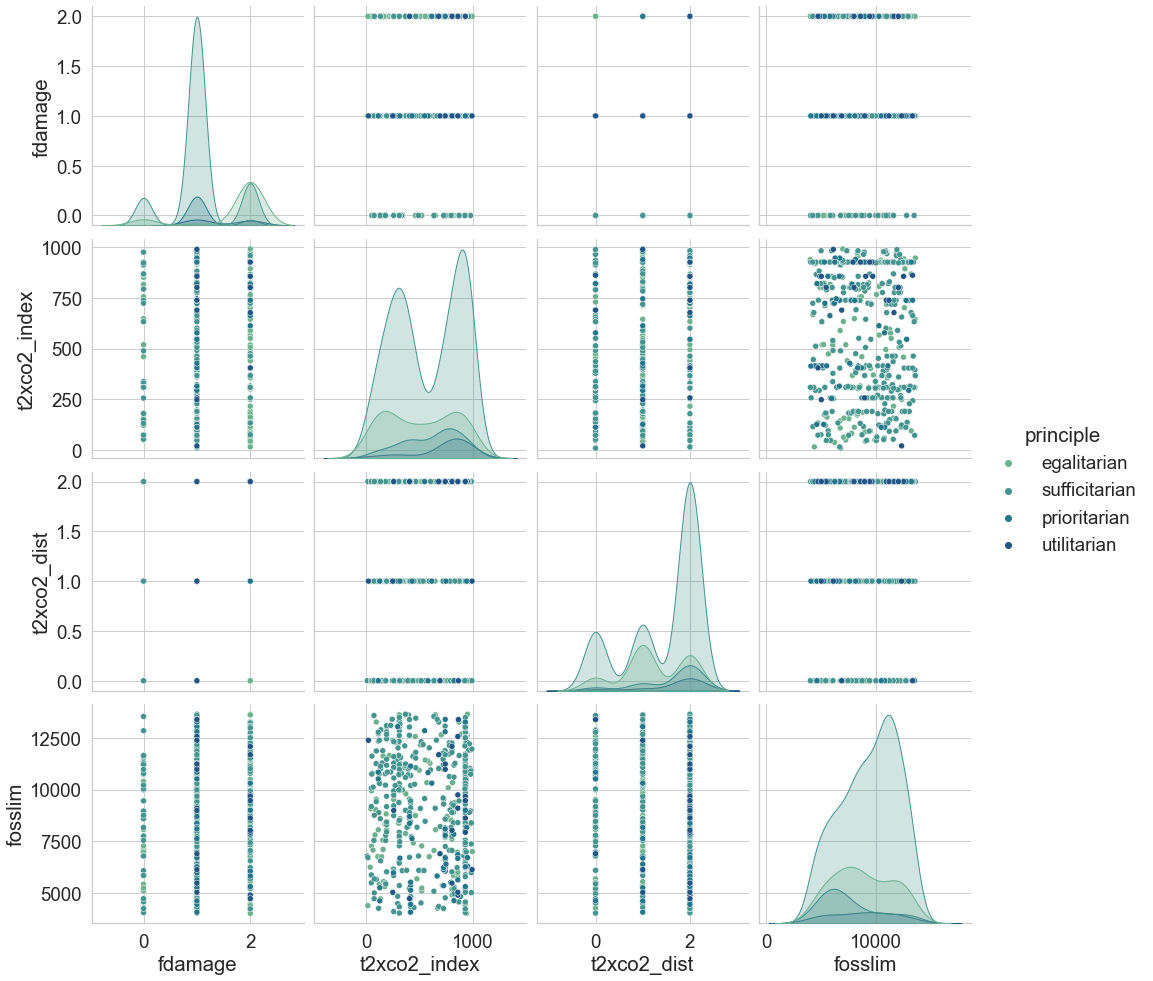

In [14]:
plot_df = total_worst_case_df.iloc[:,0:4]
plot_df["principle"] = total_worst_case_df['principle']

sns.set(font_scale=1.7)# crazy big
sns.set_style("whitegrid")

k = sns.pairplot(plot_df, hue="principle", height=3.5,palette = 'crest')

k.savefig('Distribution of worst-case climate uncertainties.png',dpi = 200)


## Distribution worst-case of socio economic uncertainties

In [15]:
plot_df.shape

(490, 5)

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


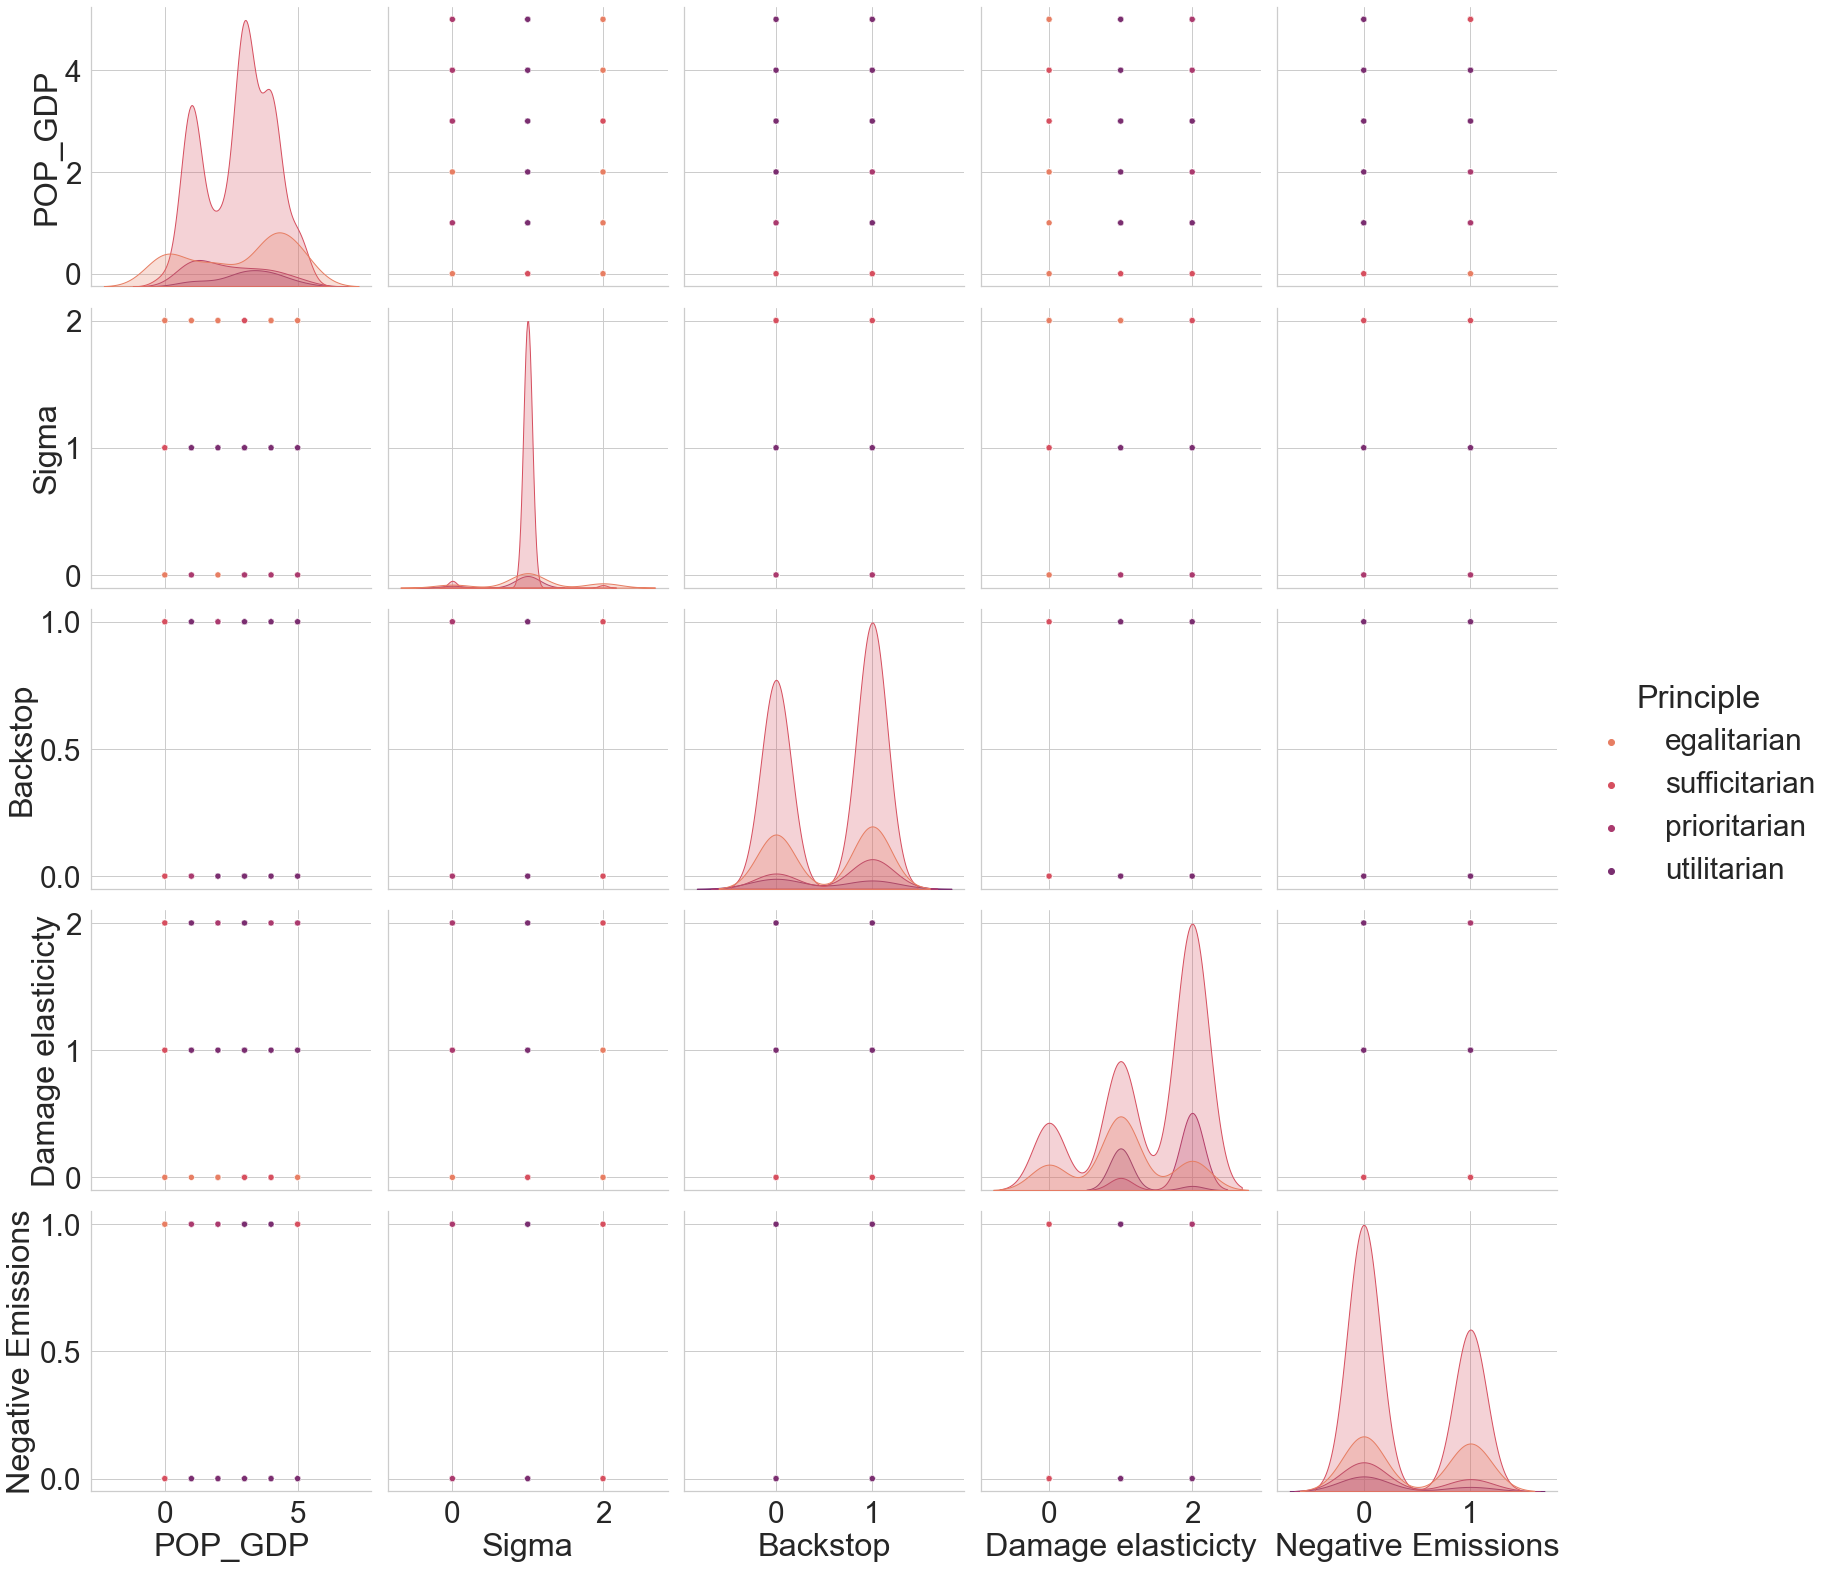

In [26]:
plot_df = total_worst_case_df.iloc[:,4:9] 
plot_df["principle"] = total_worst_case_df['principle']
plot_df.columns = ["POP_GDP","Sigma","Backstop","Damage elasticicty","Negative Emissions","Principle"]

sns.set(font_scale=2.7)
sns.set_style("whitegrid")

k = sns.pairplot(plot_df, hue="Principle", height=4.5,palette = 'flare')

k.savefig('Distribution worst-case of socio economic uncertainties.png',dpi = 200)

In [17]:
outcomes_prio = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"].iloc[:, np.r_[22:26,37]]
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,np.r_[17:21,37]]
outcomes_ega= total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,np.r_[11:15,37]]
outcomes_util= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"].iloc[:,np.r_[26:28,37]]
outcomes_util['Total Aggregated Utility']= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['Total Aggregated Utility']
outcomes_util = outcomes_util[["Utility 2055","Utility 2105", "Total Aggregated Utility","discounting_method"]]
outcomes_split = [outcomes_prio,outcomes_suf,outcomes_ega,outcomes_util]

# Get top 50 suf and ega worst cases

In [18]:
total_worst_case_df_prin = total_worst_case_df[total_worst_case_df['principle'] == "sufficitarian"]
total_worst_case_df_prin = total_worst_case_df_prin.sort_values(by=['Population under treshold 2105','Distance to treshold 2105'],ascending = False)
total_worst_case_df_top_50_suf = total_worst_case_df_prin.iloc[0:50,:]

In [19]:
total_worst_case_df_prin = total_worst_case_df[total_worst_case_df['principle'] == "egalitarian"]
total_worst_case_df_prin = total_worst_case_df_prin.sort_values(by=['Intertemporal impact GINI','Intratemporal impact GINI 2105'],ascending = False)
total_worst_case_df_top_50_ega = total_worst_case_df_prin.iloc[0:50,:]

In [20]:
reduced_worst_off = pd.concat([total_worst_case_df_top_50_suf,total_worst_case_df_top_50_ega,
                               total_worst_case_df[total_worst_case_df['principle'] == "prioritarian"],
                               total_worst_case_df[total_worst_case_df['principle'] == "utilitarian"]],axis=0)

### Get data for climate uncertainties

In [21]:
climate_uncertainties = reduced_worst_off.iloc[:, np.r_[0:4,7, 15,37]]

In [22]:
limits = parcoords.get_limits(climate_uncertainties.iloc[:, :-1])

labels_discounting = ["descriptive strategies","prescriptive strategies","no discounting strategies",
          "worst-off conditional discounting","inheritance discounting","growth discounting",
          "intergenerational equality","no discounting"]

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


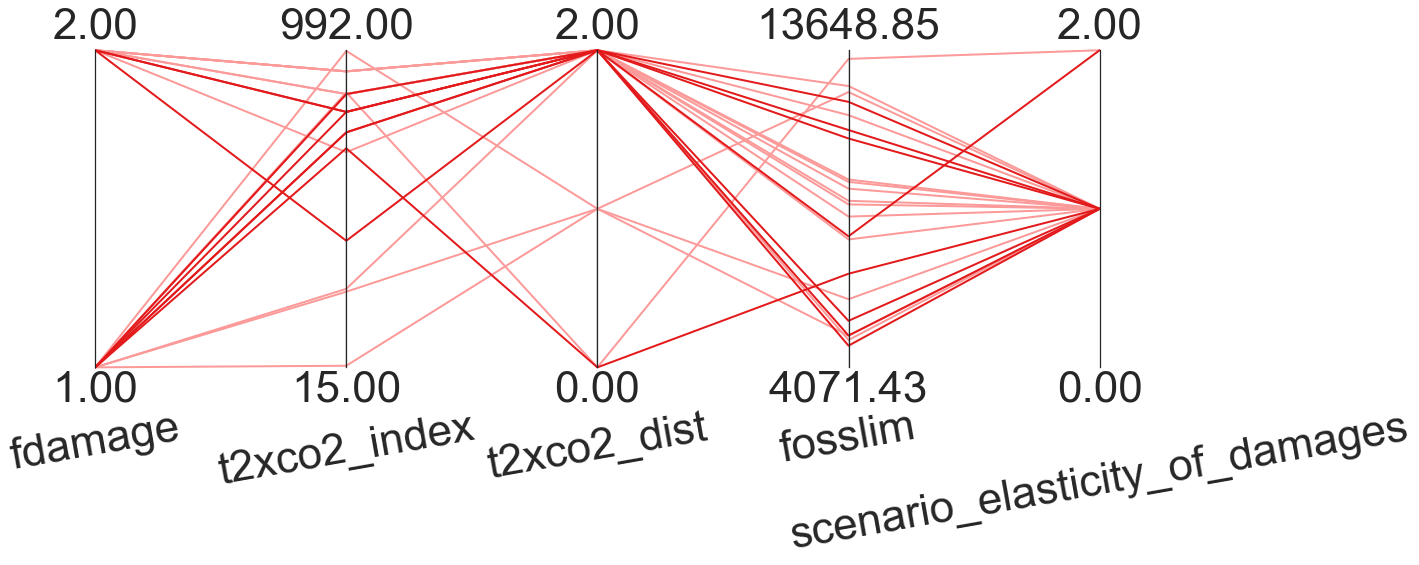

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


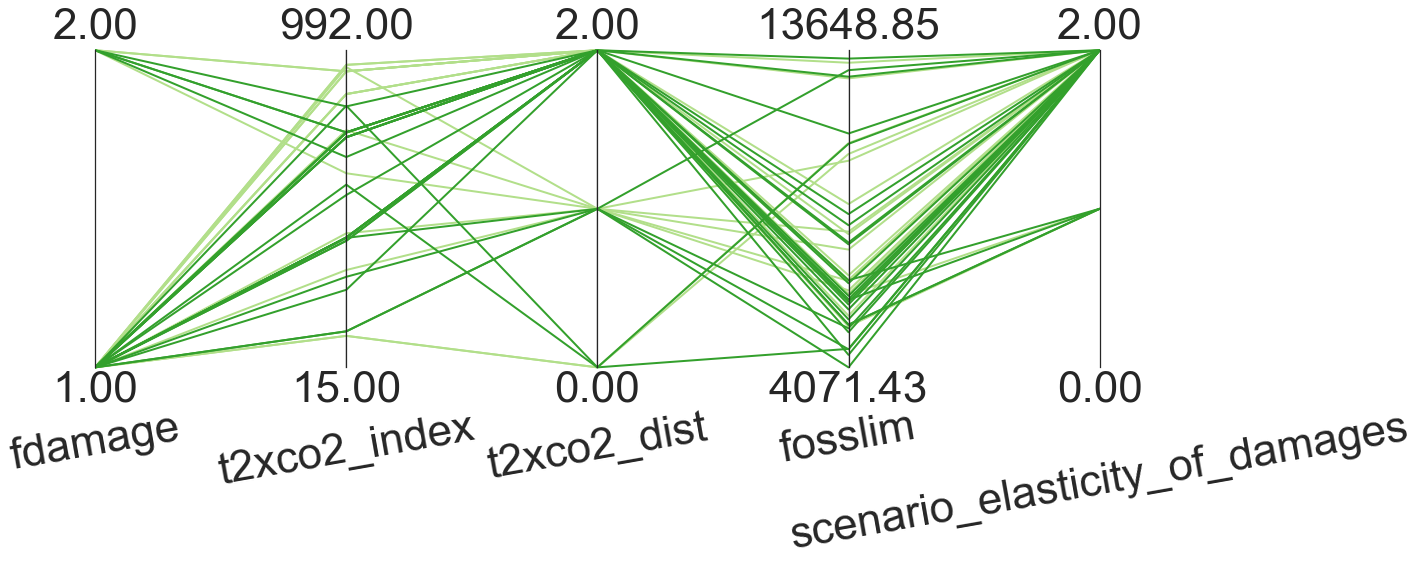

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


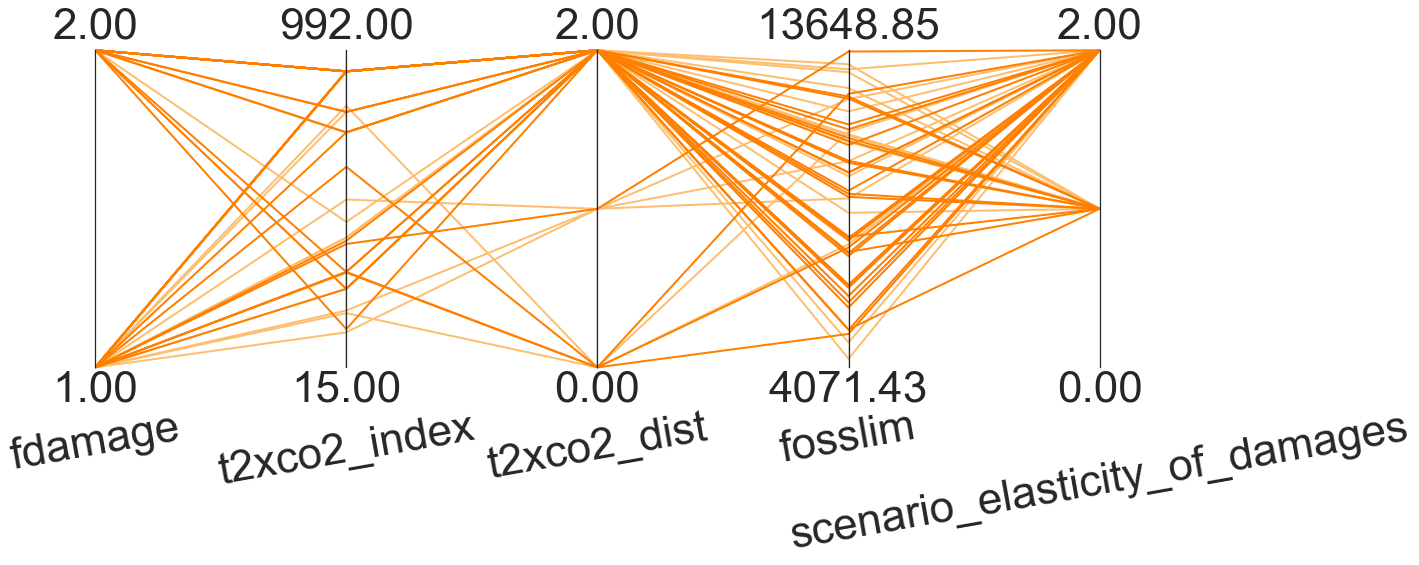

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(h_pad=0, w_pad=0)


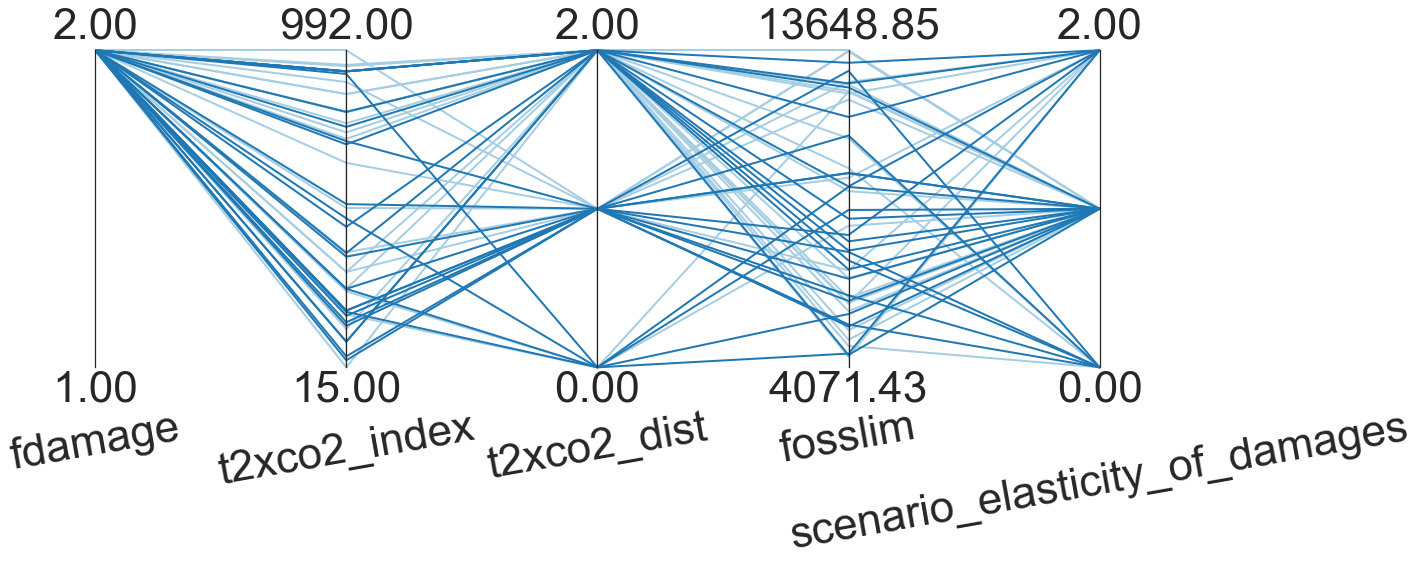

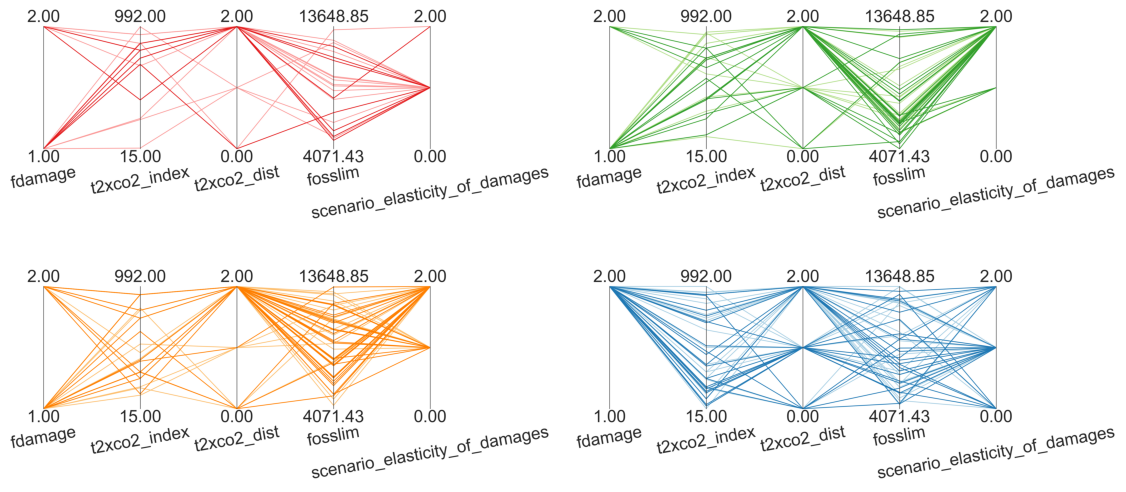

In [23]:
#Rename columns
#paraxes = parcoords.ParallelAxes(climate_uncertainties.iloc[:,:4], rot=10, fontsize=24)
#paraxes.fig.set_size_inches(16,8)

principles = ["utilitarian","prioritarian","sufficitarian","egalitarian"]

priciple_index = 0
discounting_method = [0,1,2,3,4,5,6,7]
discounting_method_index = 0

for principle in principles:
    paraxes = parcoords.ParallelAxes(climate_uncertainties.iloc[:,:5], rot=10, fontsize=44)
    paraxes.fig.set_size_inches(18,7)
    for i in range(0,2):
        worst_cases_to_plot = climate_uncertainties[
            (climate_uncertainties['principle'] == principle)  & 
            (climate_uncertainties['discounting_method'] == discounting_method[discounting_method_index]) ]
                
        if principle == "egalitarian":
            color = sns.color_palette("Paired")[0+i]
        if principle == "utilitarian":
            color = sns.color_palette("Paired")[4+i]
        if principle == "sufficitarian":
            color = sns.color_palette("Paired")[6+i]
        if principle == "prioritarian":
            color = sns.color_palette("Paired")[2+i]
    
        paraxes.plot(worst_cases_to_plot,color = color,linewidth=2, label =principles[priciple_index]+ " " + labels_discounting[discounting_method_index]  )

        discounting_method_index = discounting_method_index + 1

    priciple_index = priciple_index + 1


    plt.show()
    
    paraxes.fig.savefig("worst_case_climate_objectives_"+ str(priciple_index) + ".png", bbox_inches='tight',dpi = 200)
    plt.close()


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(16, 8))

axarr[0,0].imshow(mpimg.imread('worst_case_climate_objectives_1.png'))
axarr[0,1].imshow(mpimg.imread('worst_case_climate_objectives_2.png'))
axarr[1,0].imshow(mpimg.imread('worst_case_climate_objectives_3.png'))
axarr[1,1].imshow(mpimg.imread('worst_case_climate_objectives_4.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("composition of climate uncertanties worst case.png", dpi=200)

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

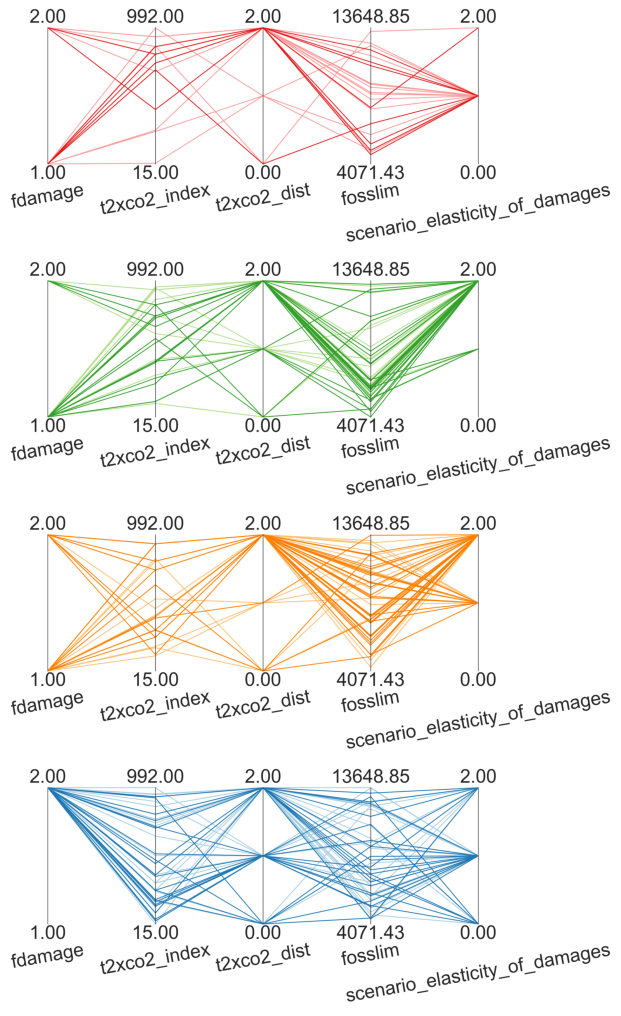

In [35]:
fig2 = plt.figure(constrained_layout=True,figsize=(30,14))
spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0],frameon=False)
f2_ax2 = fig2.add_subplot(spec2[1],frameon=False)
f2_ax3 = fig2.add_subplot(spec2[2],frameon=False)
f2_ax4 = fig2.add_subplot(spec2[3],frameon=False)

f2_ax1.axes.get_yaxis().set_visible(False)
f2_ax2.axes.get_yaxis().set_visible(False)
f2_ax3.axes.get_yaxis().set_visible(False)
f2_ax4.axes.get_yaxis().set_visible(False)

f2_ax1.axes.get_xaxis().set_visible(False)
f2_ax2.axes.get_xaxis().set_visible(False)
f2_ax3.axes.get_xaxis().set_visible(False)
f2_ax4.axes.get_xaxis().set_visible(False)

f2_ax1.imshow(mpimg.imread('worst_case_climate_objectives_1.png'))
f2_ax2.imshow(mpimg.imread('worst_case_climate_objectives_2.png'))
f2_ax3.imshow(mpimg.imread('worst_case_climate_objectives_3.png'))
f2_ax4.imshow(mpimg.imread('worst_case_climate_objectives_4.png'))

fig2.savefig("worst_case_parcoords_climate_uncertainties.png", dpi=250,bbox_inches='tight')

## Paralell coordinates plot socio economic uncertainties

In [36]:
socio_uncertainties = reduced_worst_off.iloc[:, np.r_[4:7,8]]#, 15,37]]
socio_uncertainties_shape =socio_uncertainties + np.random.rand(*socio_uncertainties.shape) / 30

socio_uncertainties_shape = pd.concat([socio_uncertainties_shape,reduced_worst_off.iloc[:, np.r_[15,37]]],axis=1)

In [37]:
limits = parcoords.get_limits(socio_uncertainties.iloc[:, :-1])

labels_discounting = ["descriptive strategies","prescriptive strategies","no discounting strategies",
          "worst-off conditional discounting","inheritance discounting","growth discounting",
          "intergenerational equality","no discounting"]

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


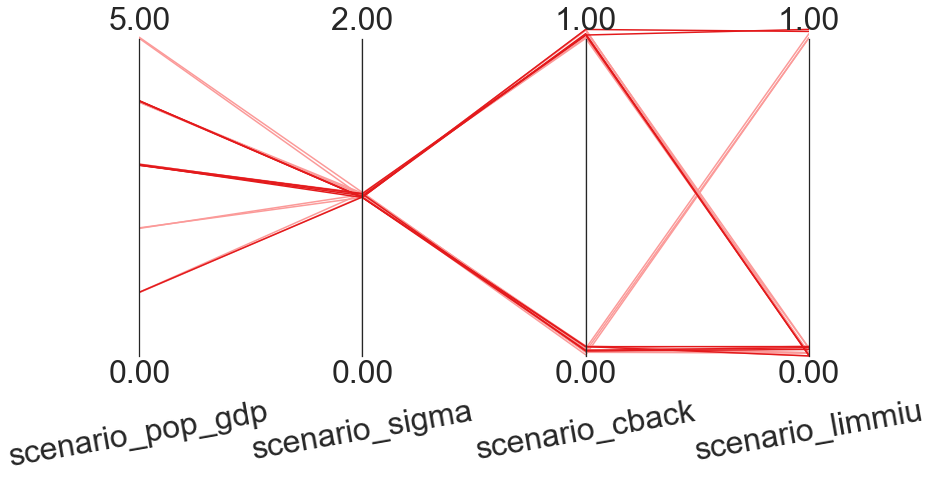

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


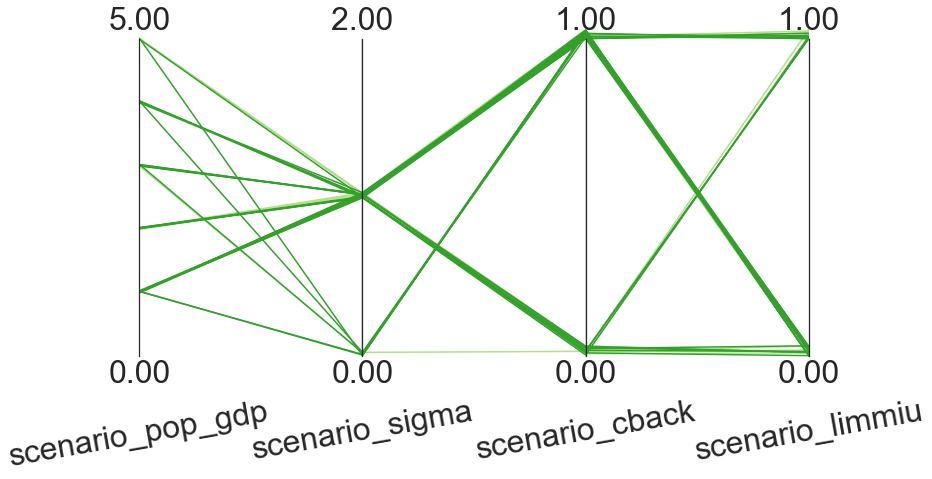

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


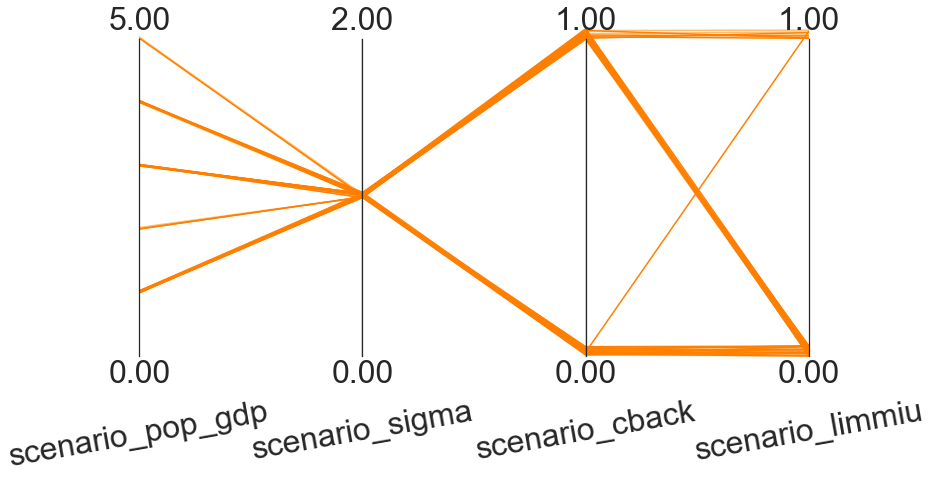

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


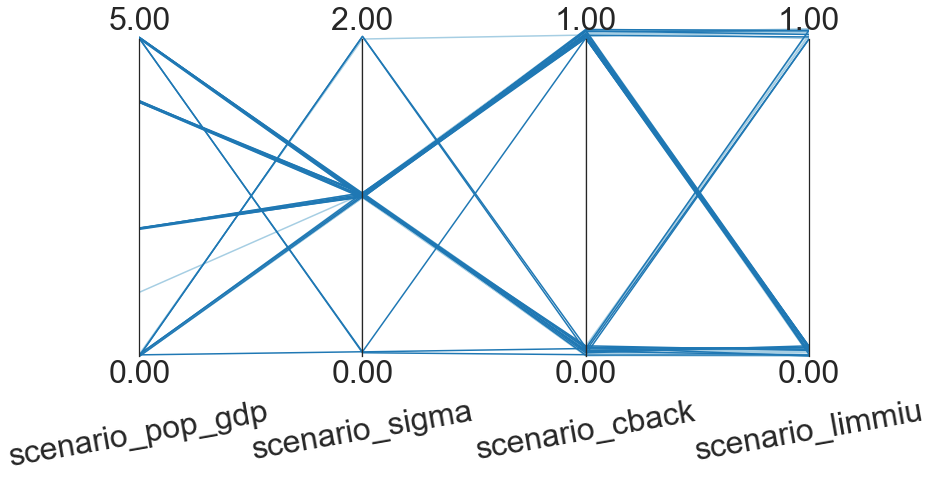

In [38]:
#Rename columns
#paraxes = parcoords.ParallelAxes(climate_uncertainties.iloc[:,:4], rot=10, fontsize=24)
#paraxes.fig.set_size_inches(16,8)

principles = ["utilitarian","prioritarian","sufficitarian","egalitarian"]

priciple_index = 0
discounting_method = [0,1,2,3,4,5,6,7]
discounting_method_index = 0

for principle in principles:
    paraxes = parcoords.ParallelAxes(socio_uncertainties.iloc[:,:4], rot=10, fontsize=32)
    paraxes.fig.set_size_inches(12,7)
    for i in range(0,2):
        worst_cases_to_plot = socio_uncertainties_shape[
            (socio_uncertainties_shape['principle'] == principle)  & 
            (socio_uncertainties_shape['discounting_method'] == discounting_method[discounting_method_index]) ]
                
        if principle == "egalitarian":
            color = sns.color_palette("Paired")[0+i]
        if principle == "utilitarian":
            color = sns.color_palette("Paired")[4+i]
        if principle == "sufficitarian":
            color = sns.color_palette("Paired")[6+i]
        if principle == "prioritarian":
            color = sns.color_palette("Paired")[2+i]
    
        paraxes.plot(worst_cases_to_plot,color = color, label =principles[priciple_index]+ " " + labels_discounting[discounting_method_index] )
        discounting_method_index = discounting_method_index + 1
    priciple_index = priciple_index + 1

    #paraxes.legend()
    plt.show()
    
    paraxes.fig.savefig("worst_case_socio_objectives_"+ str(priciple_index) + ".png", bbox_inches='tight',dpi = 200)
    plt.close()


C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


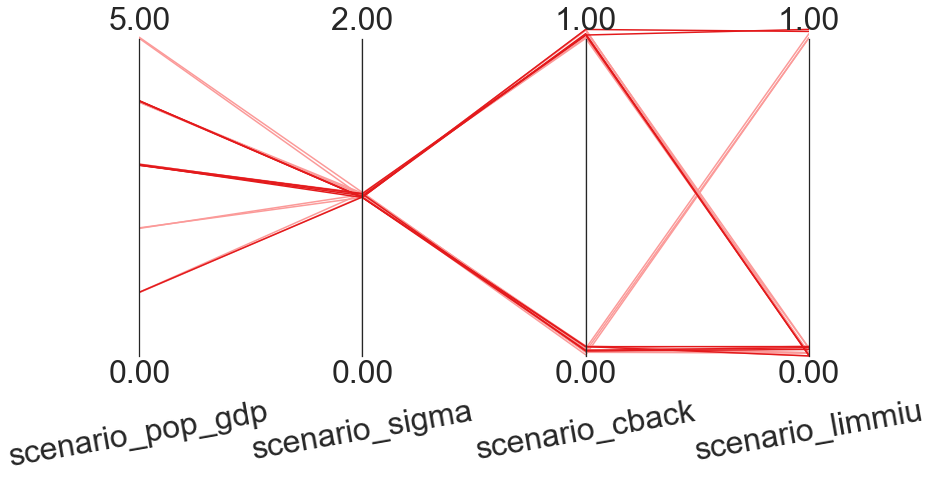

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


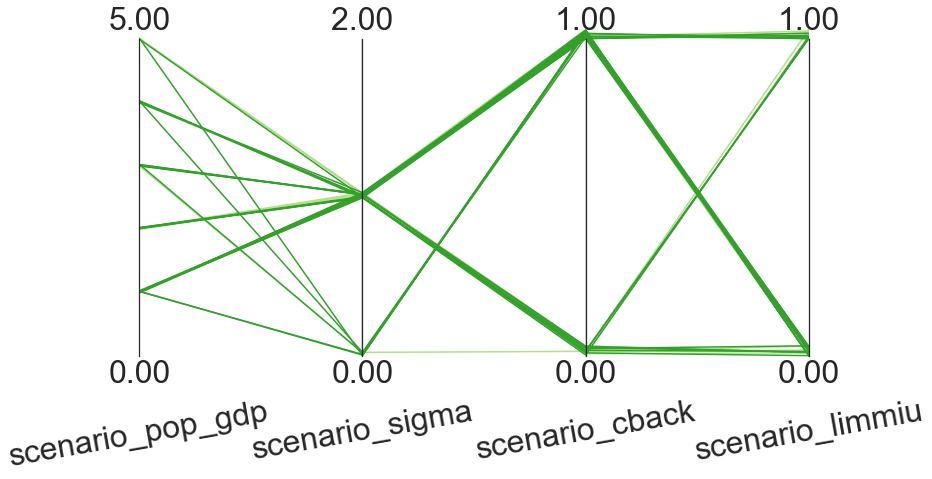

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


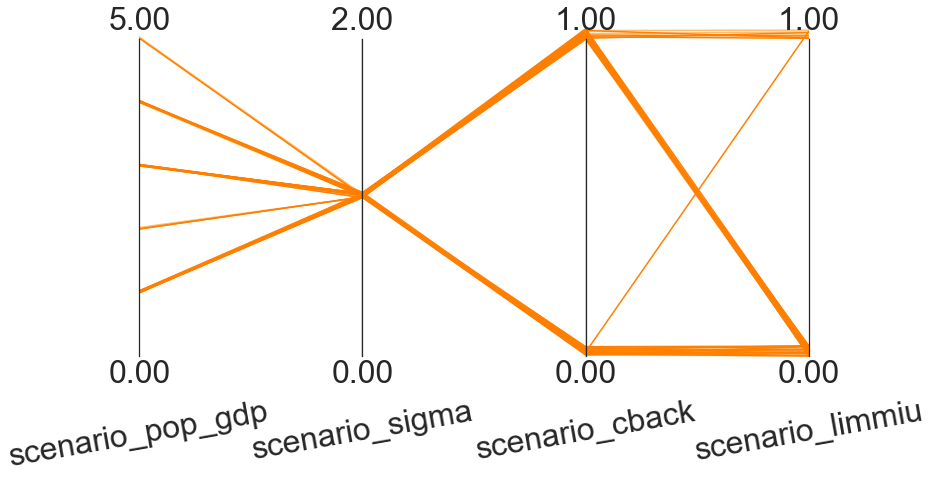

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


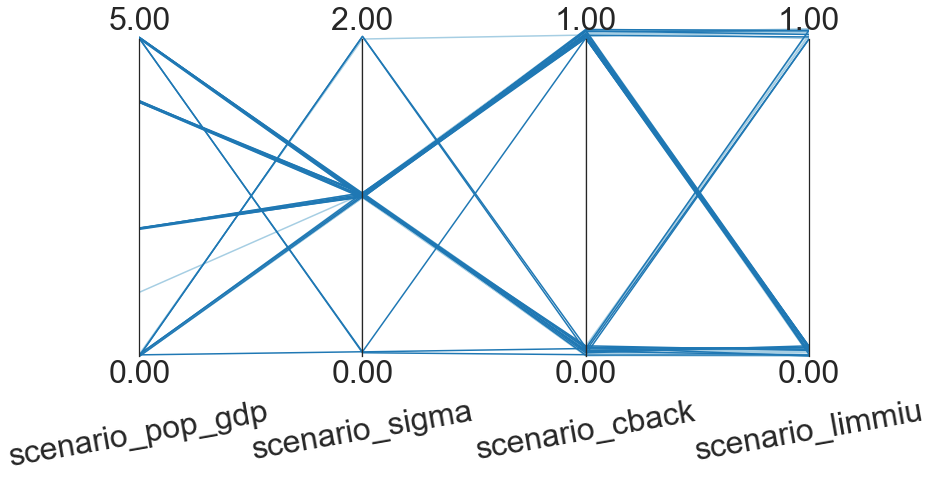

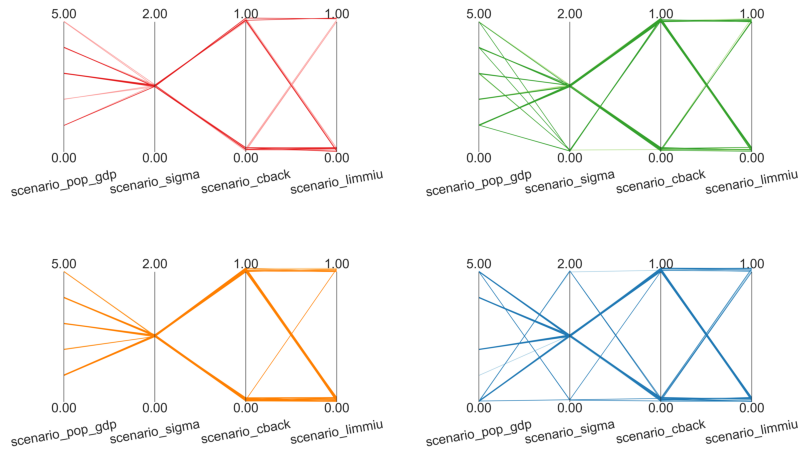

In [39]:
#Rename columns
#paraxes = parcoords.ParallelAxes(climate_uncertainties.iloc[:,:4], rot=10, fontsize=24)
#paraxes.fig.set_size_inches(16,8)

principles = ["utilitarian","prioritarian","sufficitarian","egalitarian"]

priciple_index = 0
discounting_method = [0,1,2,3,4,5,6,7]
discounting_method_index = 0

for principle in principles:
    paraxes = parcoords.ParallelAxes(socio_uncertainties.iloc[:,:4], rot=10, fontsize=32)
    paraxes.fig.set_size_inches(12,7)
    for i in range(0,2):
        worst_cases_to_plot = socio_uncertainties_shape[
            (socio_uncertainties_shape['principle'] == principle)  & 
            (socio_uncertainties_shape['discounting_method'] == discounting_method[discounting_method_index]) ]
                
        if principle == "egalitarian":
            color = sns.color_palette("Paired")[0+i]
        if principle == "utilitarian":
            color = sns.color_palette("Paired")[4+i]
        if principle == "sufficitarian":
            color = sns.color_palette("Paired")[6+i]
        if principle == "prioritarian":
            color = sns.color_palette("Paired")[2+i]
    
        paraxes.plot(worst_cases_to_plot,color = color, label =principles[priciple_index]+ " " + labels_discounting[discounting_method_index] )
        discounting_method_index = discounting_method_index + 1
    priciple_index = priciple_index + 1

    #paraxes.legend()
    plt.show()
    
    paraxes.fig.savefig("worst_case_socio_objectives_"+ str(priciple_index) + ".png", bbox_inches='tight',dpi = 200)
    plt.close()


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(12, 8))

axarr[0,0].imshow(mpimg.imread('worst_case_socio_objectives_1.png'))
axarr[0,1].imshow(mpimg.imread('worst_case_socio_objectives_2.png'))
axarr[1,0].imshow(mpimg.imread('worst_case_socio_objectives_3.png'))
axarr[1,1].imshow(mpimg.imread('worst_case_socio_objectives_4.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

f.savefig("composition_worst_case_socio_economic_quatro.png", dpi=200)

## Distribution worst-case prioritarian outcomes

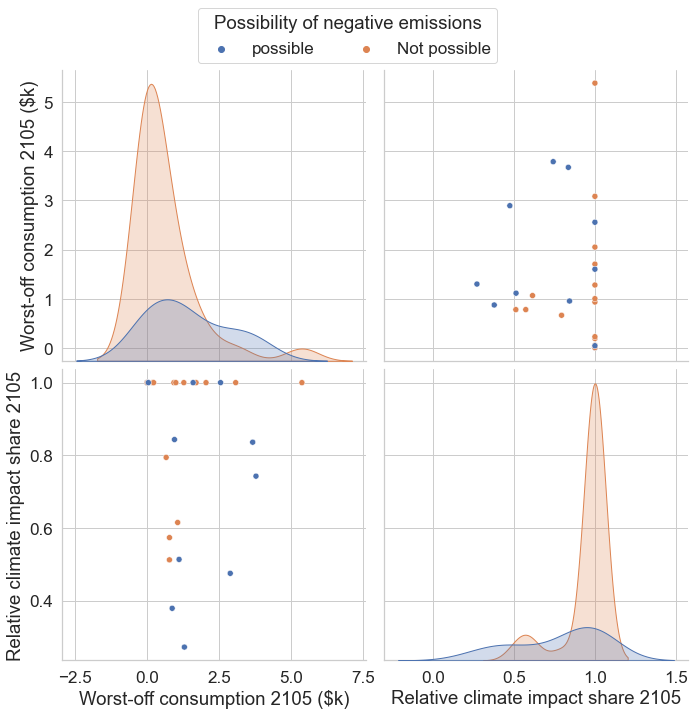

In [61]:
outcomes_prio = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"].iloc[:,24:26]
outcomes_prio['Negative emissions'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_limmiu"]
outcomes_prio.columns = ['Worst-off consumption 2105 ($k)','Relative climate impact share 2105', 'Possibility of negative emissions']

mapping = {0:"Not possible",1: "possible"}
outcomes_prio = outcomes_prio.replace({"Possibility of negative emissions": mapping})

sns.set(font_scale=1.55)
sns.set_style("whitegrid")

k = sns.pairplot(outcomes_prio,hue = "Possibility of negative emissions", height=5)
#k.set(ylabel='Worst-off consumption 2105 ($k)')

k._legend.remove()

handles = k._legend_data.values()
labels = k._legend_data.keys()
k.fig.legend(title='Possibility of negative emissions', handles=handles, labels=labels, loc='upper center', ncol=3)
k.fig.subplots_adjust(top=0.90, bottom=0.08)

k.savefig('Distribution worst-case prioritarian outcomes limmiu.png',dpi = 200)


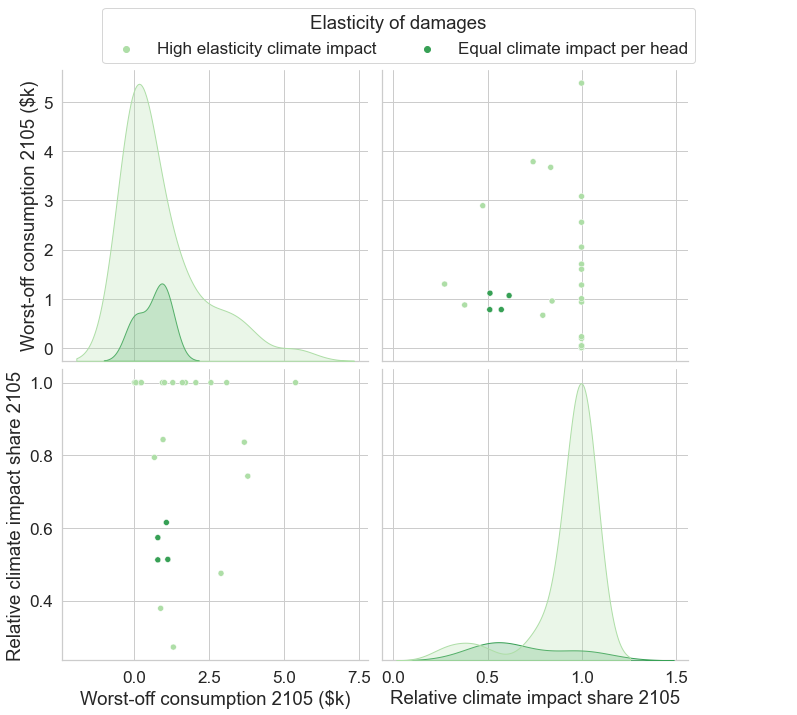

In [60]:
sns.set(font_scale=1.55)
sns.set_style("whitegrid")
outcomes_prio['Elasticity of damages'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]
outcomes_prio = outcomes_prio.drop(['Possibility of CDR'],axis=1)

mapping = {1:"Equal climate impact per head",2: "High elasticity climate impact"}
outcomes_prio = outcomes_prio.replace({"Elasticity of damages": mapping})

k = sns.pairplot(outcomes_prio.iloc[:,:],hue = "Elasticity of damages", height=5,palette='Greens')

k._legend.remove()

handles = k._legend_data.values()
labels = k._legend_data.keys()
k.fig.legend(title='Elasticity of damages', handles=handles, labels=labels, loc='upper center', ncol=3)
k.fig.subplots_adjust(top=0.90, bottom=0.08)

k.savefig('Distribution worst-case prioritarian outcomes damage elasticity.png',dpi = 200)


## Distribution worst-case sufficitarian outcomes

In [38]:
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,17:21]
outcomes_suf['efficiency scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"]["scenario_sigma"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_suf,hue='efficiency scenario', height=4)

In [41]:
k

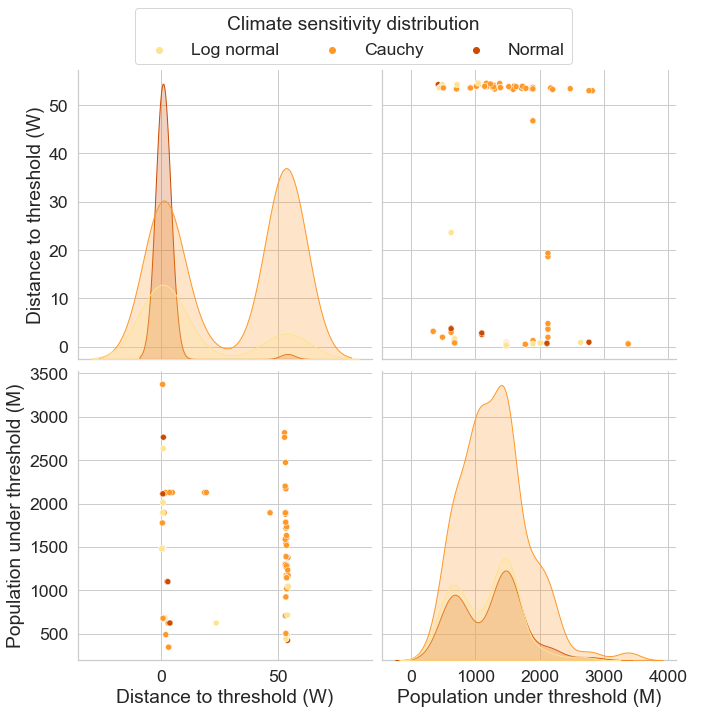

In [48]:
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,17:21]
outcomes_suf['climate sensitivity distribution'] = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"]["t2xco2_dist"]

sns.set(font_scale=1.6)
sns.set_style("whitegrid")

data = outcomes_suf.iloc[:,2:]
data.columns = ['Distance to threshold (W)','Population under threshold (M)',"Climate sensitivity distribution"]

mapping = {0:"Normal",1: "Log normal",2:"Cauchy"}

data = data.replace({"Climate sensitivity distribution": mapping})

k = sns.pairplot(data,hue='Climate sensitivity distribution', height=5,palette='YlOrBr')
k._legend.remove()

handles = k._legend_data.values()
labels = k._legend_data.keys()
k.fig.legend(title='Climate sensitivity distribution', handles=handles, labels=labels, loc='upper center', ncol=3)
k.fig.subplots_adjust(top=0.90, bottom=0.08)

k.savefig('Distribution worst-case sufficitarian outcomes climate sens dist relation.png',dpi = 200)


In [44]:
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,17:21]
outcomes_suf['negative emission scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"]["scenario_limmiu"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

##sns.pairplot(outcomes_suf,hue='negative emission scenario', height=4)

In [45]:
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,17:21]
outcomes_suf['economic scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"]["scenario_pop_gdp"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_suf,hue='economic scenario', height=4)

In [46]:
outcomes_suf= total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"].iloc[:,17:21]
outcomes_suf['assumed damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="sufficitarian"]["scenario_elasticity_of_damages"]
#outcomes_prio['damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_suf, hue='assumed damage relation',height=4)

## Distribution worst-case egalitarian outcomes

In [45]:
outcomes_ega= total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,11:15]
outcomes_ega['efficiency scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"]["scenario_sigma"]
#outcomes_prio['damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_ega, hue='efficiency scenario',height=4)

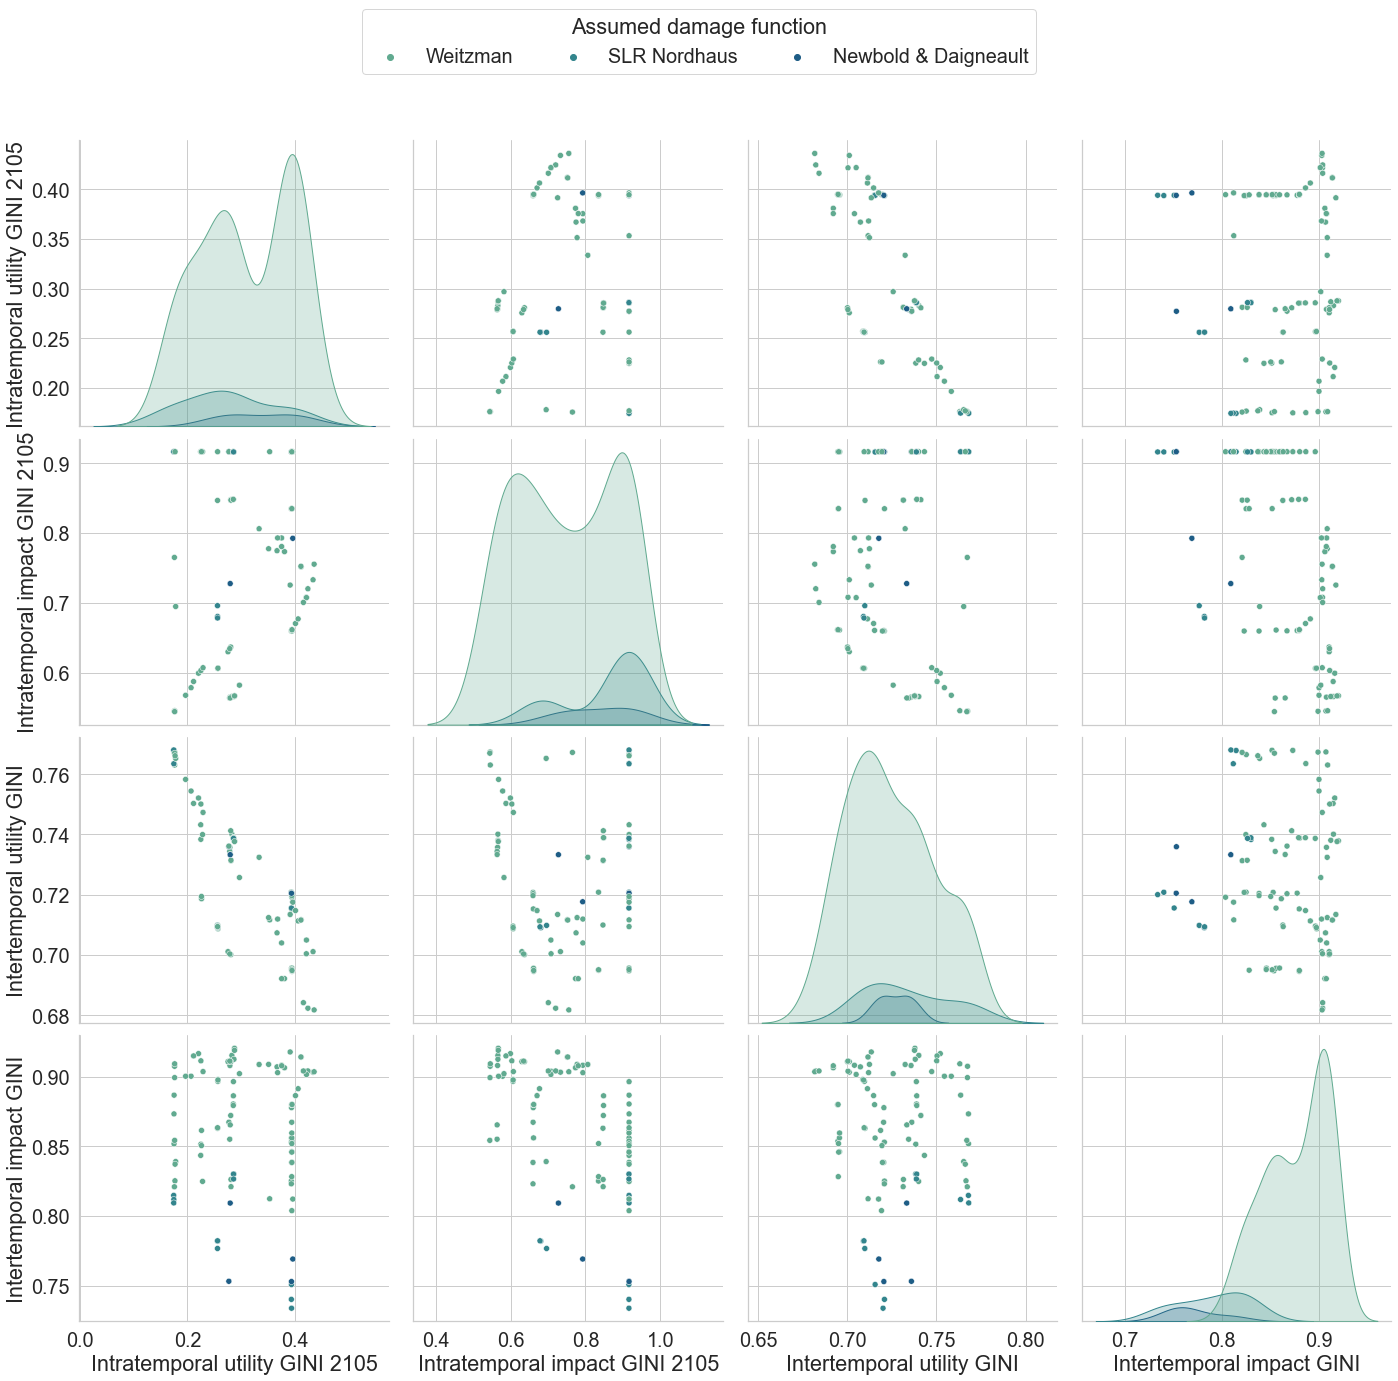

In [50]:
outcomes_ega= total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,11:15]
outcomes_ega['assumed damage function'] = total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"]["fdamage"]
#outcomes_prio['damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]

sns.set(font_scale=1.8)
sns.set_style("whitegrid")

mapping = {0:"SLR Nordhaus",1: "Newbold & Daigneault",2:"Weitzman"}
outcomes_ega = outcomes_ega.replace({"assumed damage function": mapping})

k = sns.pairplot(outcomes_ega, hue='assumed damage function',height=5,palette = 'crest')

k._legend.remove()

handles = k._legend_data.values()
labels = k._legend_data.keys()
k.fig.legend(title='Assumed damage function', handles=handles, labels=labels, loc='upper center', ncol=3)
k.fig.subplots_adjust(top=0.90, bottom=0.08)

k.savefig('Distribution worst-case egalitarian outcomes climate damage function.png',dpi = 200)


In [49]:
outcomes_ega= total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,11:15]
outcomes_ega['assumed damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"]["scenario_elasticity_of_damages"]
#outcomes_prio['damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_ega, hue='assumed damage relation',height=4)

In [50]:
outcomes_ega= total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"].iloc[:,11:15]
outcomes_ega['economic scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="egalitarian"]['scenario_pop_gdp']
#outcomes_prio['damage relation'] = total_worst_case_df[total_worst_case_df["principle"]=="prioritarian"]["scenario_elasticity_of_damages"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_ega, hue='economic scenario',height=4)

## Distribution worst-case utilitarian outcomes

In [52]:
outcomes_util

Utility 2055  Utility 2105  aggregated utility  \
index_label                                                            
policy857utilitarian   5302.808960   -506.168927         3465.813517   
policy857utilitarian   2928.007744   2051.897584         1929.197532   
policy857utilitarian   4532.153373   1346.803346         2685.455085   
policy857utilitarian   4792.088217   1213.004235         2688.560017   
policy857utilitarian   2639.395362   1902.697880         2095.089819   
policy417utilitarian   3573.091398    167.757089         1408.715657   
policy417utilitarian   2246.296629   1473.915807          893.996049   
policy417utilitarian   3947.559141   -773.720555         1907.078942   
policy417utilitarian   2109.904938    400.995339          998.046301   
policy417utilitarian   3382.936062    286.173386         1396.421635   
policy417utilitarian   1970.565531   1033.684658          997.992787   
policy79utilitarian    3245.581992   3320.961971         2294.004663   
policy79utilitarian    3243.653013   3366.078765         2295.053641   
policy79utilitarian    2867.940975   2534.558444         2421.098393   
policy132utilitarian   3339.150638   2754.372115         2536.297961   
policy132utilitarian   5458.952714    422.272195         3376.571107   
policy132utilitarian   3201.628338    863.110920         2684.066474   
policy132utilitarian   3015.398818   2468.070226         2715.318863   
policy132utilitarian   3353.349728   2701.858219         2539.310875   
policy370utilitarian   4396.588513    980.618912         3620.443556   
policy370utilitarian   4198.313510   5309.988444         3747.644432   
policy370utilitarian   3690.283580   3737.223311         3867.365012   

                     Possibility of negative emissions  
index_label                                             
policy857utilitarian                      Not possible  
policy857utilitarian                      Not possible  
policy857utilitarian                      Not possible  
policy857utilitarian                      Not possible  
policy857utilitarian                      Not possible  
policy417utilitarian                      Not possible  
policy417utilitarian                      Not possible  
policy417utilitarian                      Not possible  
policy417utilitarian                          possible  
policy417utilitarian                      Not possible  
policy417utilitarian                          possible  
policy79utilitarian                       Not possible  
policy79utilitarian                           possible  
policy79utilitarian                       Not possible  
policy132utilitarian                          possible  
policy132utilitarian                      Not possible  
policy132utilitarian                          possible  
policy132utilitarian                      Not possible  
policy132utilitarian                      Not possible  
policy370utilitarian                      Not possible  
policy370utilitarian                      Not possible  
policy370utilitarian                      Not possible

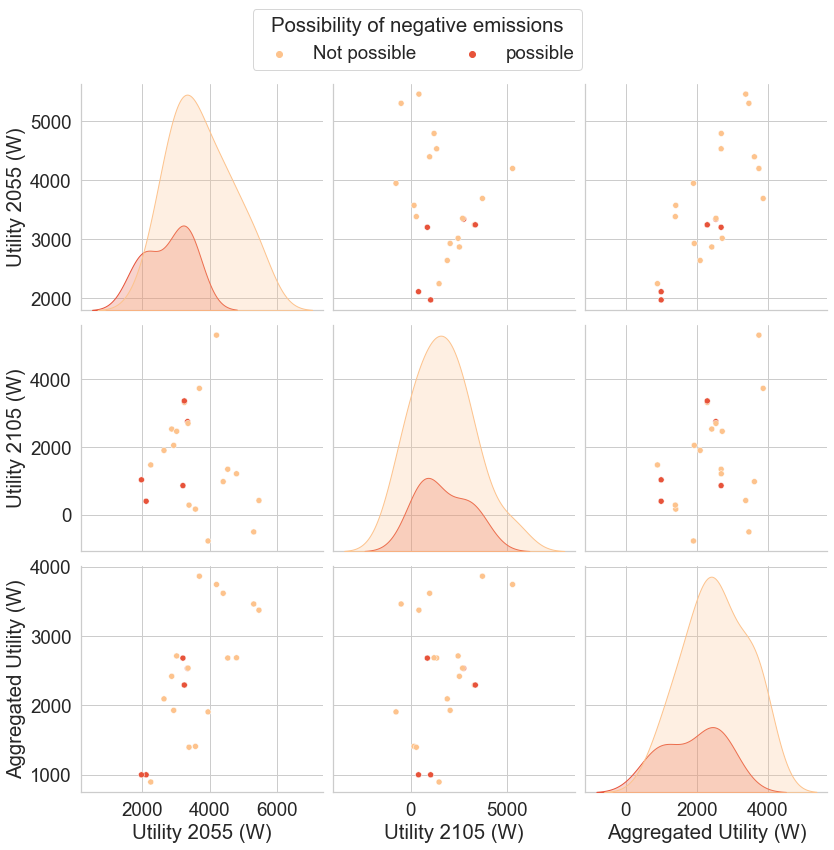

In [53]:
outcomes_util= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"].iloc[:,26:28]
outcomes_util['aggregated utility'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['Total Aggregated Utility']
outcomes_util['Possibility of negative emissions'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['scenario_limmiu']

sns.set(font_scale=1.7)

sns.set_style("whitegrid")
outcomes_util.columns = ["Utility 2055 (W)","Utility 2105 (W)","Aggregated Utility (W)","Possibility of negative emissions"]

mapping = {0:"Not possible",1: "possible"}
outcomes_util = outcomes_util.replace({"Possibility of negative emissions": mapping})

k = sns.pairplot(outcomes_util,hue = 'Possibility of negative emissions', height=4,palette = 'OrRd')

k._legend.remove()

handles = k._legend_data.values()
labels = k._legend_data.keys()
k.fig.legend(title='Possibility of negative emissions', handles=handles, labels=labels, loc='upper center', ncol=3)
k.fig.subplots_adjust(top=0.90, bottom=0.08)

k.savefig('Distribution worst-case utilitarian outcomes negative emissions.png',dpi = 200)


In [54]:
outcomes_util= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"].iloc[:,26:28]
outcomes_util['aggregated utility'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['Total Aggregated Utility']
outcomes_util['economic scenario'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['scenario_pop_gdp']

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.pairplot(outcomes_util,hue = 'economic scenario', height=4)

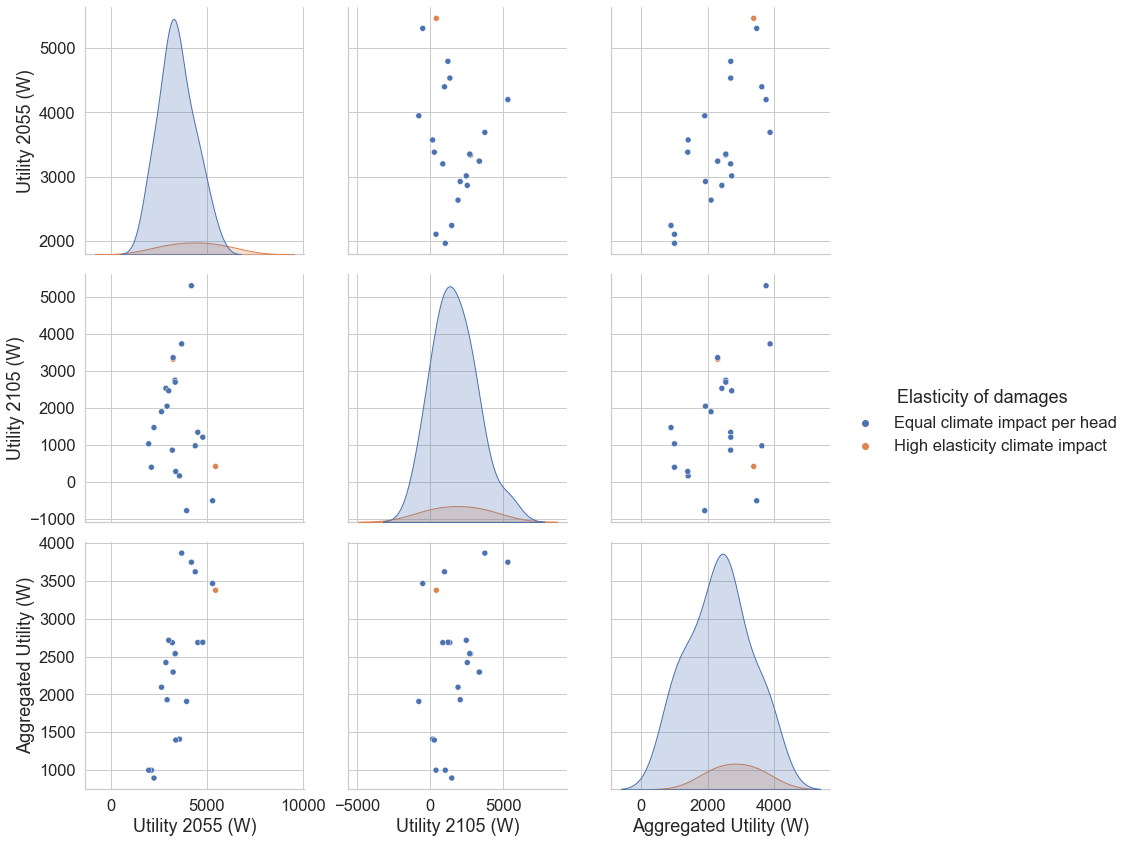

In [57]:
outcomes_util= total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"].iloc[:,26:28]
outcomes_util['aggregated utility'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['Total Aggregated Utility']
outcomes_util['Elasticity of damages'] = total_worst_case_df[total_worst_case_df["principle"]=="utilitarian"]['scenario_elasticity_of_damages']

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

mapping = {1:"Equal climate impact per head",2: "High elasticity climate impact"}
outcomes_util = outcomes_util.replace({"Elasticity of damages": mapping})

outcomes_util.columns = ["Utility 2055 (W)","Utility 2105 (W)","Aggregated Utility (W)","Elasticity of damages"]

k = sns.pairplot(outcomes_util,hue = 'Elasticity of damages', height=4)
k.savefig('Distribution worst-case utilitarian outcomes elasticity of damages.png',dpi = 200)


# Combine suf and prio plots

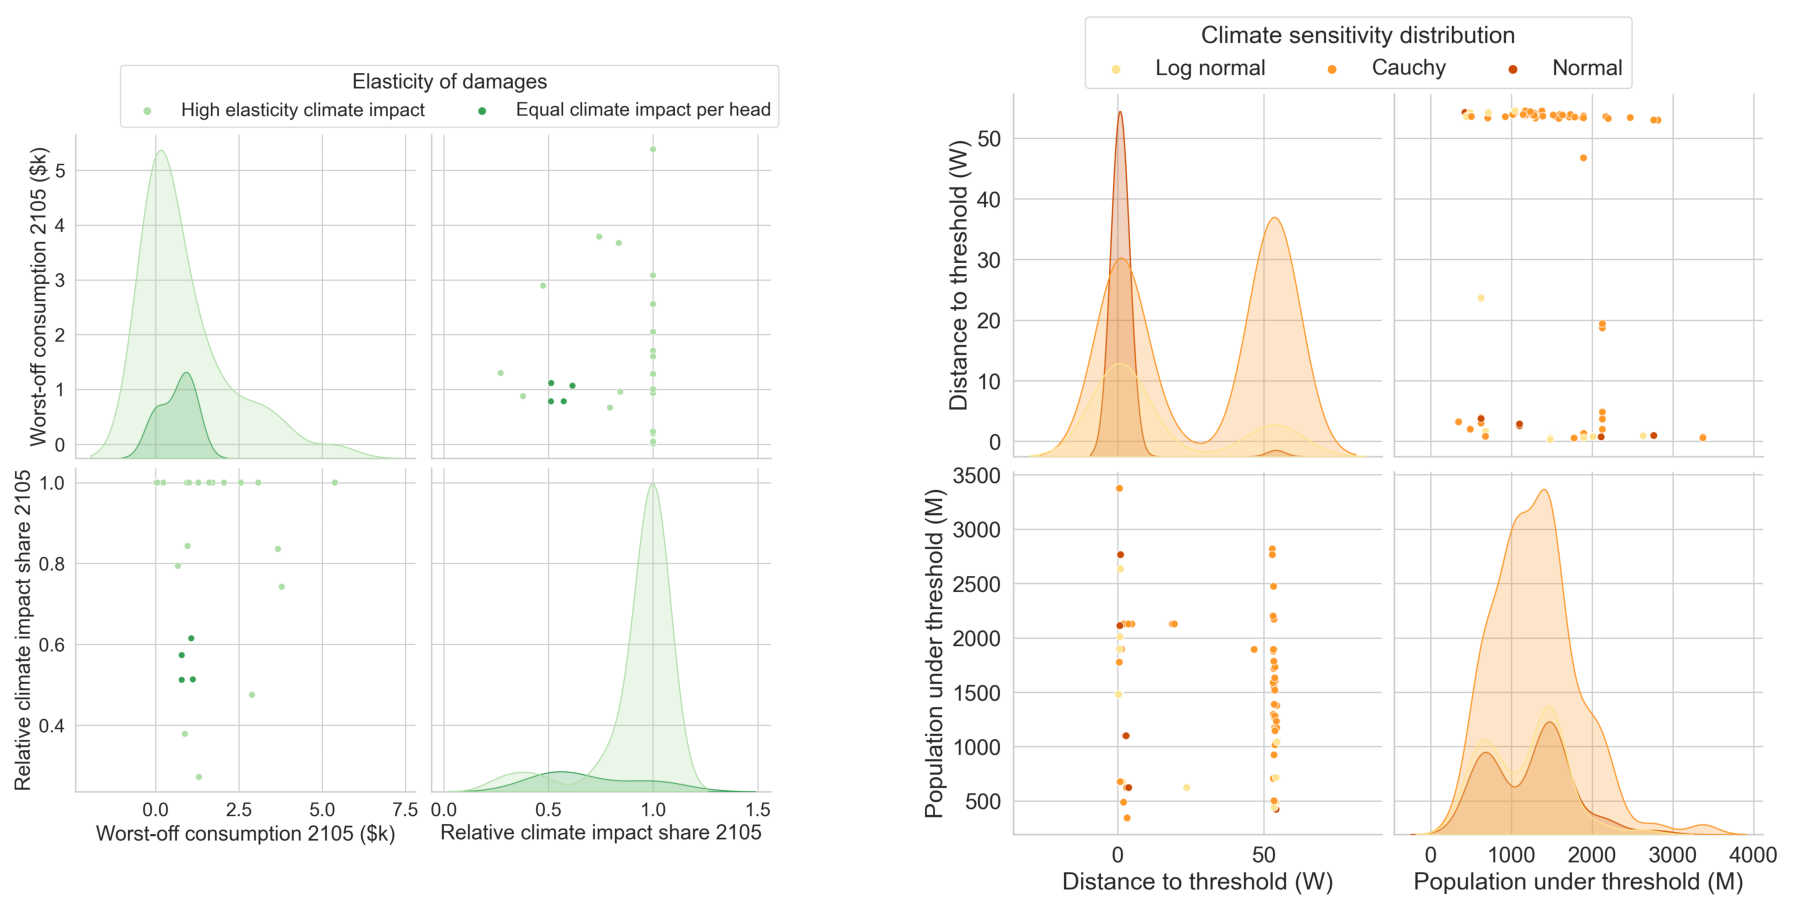

In [62]:
fig2 = plt.figure(constrained_layout=True,figsize=(25,35))
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0],frameon=False)
f2_ax2 = fig2.add_subplot(spec2[1],frameon=False)
#f2_ax3 = fig2.add_subplot(spec2[2],frameon=False)
#f2_ax4 = fig2.add_subplot(spec2[3],frameon=False)

f2_ax1.axes.get_yaxis().set_visible(False)
f2_ax2.axes.get_yaxis().set_visible(False)
#f2_ax3.axes.get_yaxis().set_visible(False)
#f2_ax4.axes.get_yaxis().set_visible(False)

f2_ax1.axes.get_xaxis().set_visible(False)
f2_ax2.axes.get_xaxis().set_visible(False)
#f2_ax3.axes.get_xaxis().set_visible(False)
#f2_ax4.axes.get_xaxis().set_visible(False)

f2_ax1.imshow(mpimg.imread('Distribution worst-case prioritarian outcomes damage elasticity.png'))
f2_ax2.imshow(mpimg.imread('Distribution worst-case sufficitarian outcomes climate sens dist relation.png'))
#f2_ax3.imshow(mpimg.imread('worst_case_climate_objectives_3.png'))
#f2_ax4.imshow(mpimg.imread('worst_case_climate_objectives_4.png'))

fig2.savefig("combined_worst_case_outcomes_prio_suf.png", dpi=200,bbox_inches='tight')